# Pre-trained network: Classifier

## Covered in this project: 

- Define the Tiny Yolo model architecture
- Load pre-trained tiny yolo weights
- Generate bottleneck features from pre-trained network
- Train fully connected layer on the bottleneck features only
- Fine-tune the entire network, while freezing the first pre-trained layers 

In [1]:
# Imports, etc.

import numpy as np
from glob import glob
from random import shuffle
import cv2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.layers import LeakyReLU

from util import WeightReader

IMAGE_SIZE=416
IMAGE_SIZE=208
NORM_H, NORM_W = 416, 416
GRID_H, GRID_W = 13 , 13
BATCH_SIZE = 8
BOX = 5
ORIG_CLASS = 20

wt_path = 'yolov2-tiny-voc.weights'
orig_weight_path = 'orig_weights.hdf5'

DATADIR = "Dataset/"
NO_CLASS_LABEL='noclass'
IMG_CHANNELS=3
TRAIN_TEST_RATIO = 0.2

epochs = 16
batch_size = 32

## Define Tiny Yolo model

In [2]:
model = Sequential()

# Layer 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(BatchNormalization(name='norm_1'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - 5
for i in range(0,4):
    model.add(Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', name='conv_'+str(2+i), use_bias=False))
    model.add(BatchNormalization(name='norm_'+str(2+i)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False))
model.add(BatchNormalization(name='norm_6'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), name='', padding='same'))

# Layer 7 - 8
for i in range(0,2):
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_'+str(7+i), use_bias=False))
    model.add(BatchNormalization(name='norm_'+str(7+i)))
    model.add(LeakyReLU(alpha=0.1))

# Layer 9
model.add(Conv2D(BOX * (4 + 1 + ORIG_CLASS), (1, 1), strides=(1, 1), name='conv_9', kernel_initializer='he_normal'))
model.add(Activation('linear'))
model.add(Flatten())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 208, 208, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 208, 208, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 208, 208, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 104, 104, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 104, 104, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 104, 104, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 104, 104, 32)      0

## Load pre-trained weights

In [3]:
# Loads weights from the .weights format available at darknet's website

weight_reader = WeightReader(wt_path)
weight_reader.reset()
nb_conv = 9

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
        


## Generate bottleneck features

In [4]:
# Read data from folder

labels = glob(DATADIR+'*/')

labels.insert(0, labels.pop(np.argmax([x.find(NO_CLASS_LABEL) for x in labels]))) # Push 'noclass' to the beginning

label_count = len(labels)
addrs = []

for (index, path) in enumerate(labels):
    img_addrs = glob(path+"*")
    for img_addr in img_addrs:
        addrs.append((img_addr, index))
        
shuffle(addrs)

division = int(len(addrs) * TRAIN_TEST_RATIO)
train_addrs = addrs[division:]
valid_addrs = addrs[0:division]

# Read dataset into memory
x_train = np.zeros( (len(train_addrs), IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS), dtype=np.int ) # Keras input: (img_height, img_width, img_depth)
y_train_list = np.zeros( len(train_addrs), dtype=np.int )

x_valid = np.zeros( (len(valid_addrs), IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS), dtype=np.int )
y_valid_list = np.zeros( len(valid_addrs), dtype=np.int )

# Train data
for i in range(len(train_addrs)):
    addr = train_addrs[i][0]
    label = train_addrs[i][1]
    img = cv2.imread(addr)
    height, width, c = img.shape
    start_col = int(max(width/2-height/2, 0))
    end_col = int(min(start_col+height, width))
    img = img[:, start_col:end_col, ... ]
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_train[i, ...] = img
    y_train_list[i] = label
    
# Validation data
for i in range(len(valid_addrs)):    
    addr = valid_addrs[i][0]
    label = valid_addrs[i][1]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_valid[i, ...] = img
    y_valid_list[i] = label
    
# One hot encode labels
y_train = np.zeros((y_train_list.shape[0],label_count),dtype=np.float)
y_valid = np.zeros((y_valid_list.shape[0],label_count),dtype=np.float)

y_train[np.arange(y_train.shape[0]), y_train_list] = 1.0
y_valid[np.arange(y_valid.shape[0]), y_valid_list] = 1.0

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1.0/255.0,)


In [5]:
x_train.shape

(500, 208, 208, 3)

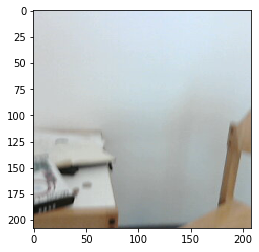

[1. 0. 0.]


In [6]:
# Test data generator

import matplotlib.pyplot as plt

gen = valid_datagen.flow(x_train, y_train, batch_size=batch_size)
x,y = gen.next()

index = 2
plt.imshow(x[index])
plt.show()
print(y[index])

In [7]:
# Generate Training features

train_features   = np.zeros((0,4500))
train_labels = np.zeros((0,3))

train_samples = 1700
iterations = int(round(train_samples/batch_size))

for i in range(iterations):

    generator = datagen.flow(x_train, y_train, batch_size=batch_size)
    x,y = next(generator)
    features = model.predict(x)
    
    train_features = np.concatenate((train_features,features))
    train_labels   = np.concatenate((train_labels, y))
    
# Validation features
valid_features   = np.zeros((0,4500))
valid_labels     = np.zeros((0,3))

valid_samples = 550
iterations = int(valid_samples/batch_size)

for i in range(iterations):

    generator = valid_datagen.flow(x_valid, y_valid, batch_size=batch_size)
    x,y = next(generator)
    features = model.predict(x)
    
    valid_features = np.concatenate((valid_features,features))
    valid_labels   = np.concatenate((valid_labels, y))


In [8]:
train_features.shape

(1696, 4500)

## Train FCN on bottleneck features

In [9]:
# Define model

from tensorflow.keras.layers import *
from tensorflow.keras import activations

bottleneck_input = Input((train_features.shape[1:]))
x = Dense(256, activation="relu")(bottleneck_input)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dense(label_count)(x)
bottleneck_output = Activation(activations.softmax)(x)

head_model = Model(inputs=bottleneck_input,outputs=bottleneck_output)
head_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4500)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               1152256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 1,168,899
Trainable params: 1,168,899
Non-trainable params: 0
___________________________________________________

In [10]:
# Compile
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

head_model.compile(optmizer=RMSprop(1e-3), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
head_model.load_weights('pre-trained.h5')

In [16]:
# Save weights

# head_model.save_weights('pre-trained.h5')
head_model.save_weights('trained.h5')

In [14]:
# Train
epochs = 17

head_model.fit(train_features, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(valid_features,valid_labels))

Train on 1696 samples, validate on 544 samples
Epoch 1/17
1696/1696 [==============================] - 0s 127us/sample - loss: 0.4345 - accuracy: 0.8750 - val_loss: 0.4492 - val_accuracy: 0.8566
Epoch 2/17
1696/1696 [==============================] - 0s 120us/sample - loss: 0.4037 - accuracy: 0.8927 - val_loss: 0.3463 - val_accuracy: 0.8915
Epoch 3/17
1696/1696 [==============================] - 0s 121us/sample - loss: 0.3235 - accuracy: 0.8968 - val_loss: 0.4227 - val_accuracy: 0.8529
Epoch 4/17
1696/1696 [==============================] - 0s 117us/sample - loss: 0.2218 - accuracy: 0.9251 - val_loss: 0.2829 - val_accuracy: 0.8971
Epoch 5/17
1696/1696 [==============================] - 0s 118us/sample - loss: 0.2127 - accuracy: 0.9387 - val_loss: 0.5799 - val_accuracy: 0.8290
Epoch 6/17
1696/1696 [==============================] - 0s 117us/sample - loss: 0.1981 - accuracy: 0.9393 - val_loss: 0.4512 - val_accuracy: 0.9062
Epoch 7/17
1696/1696 [==============================] - 0s 123us/

## Fine-tune

In [15]:
# Redefine model_head and add it to model

model_head_holder = Sequential()
model_head_holder.add(Input((train_features.shape[1:])))
model_head_holder.add(Dense(256, activation="relu"))
model_head_holder.add(Dropout(0.5))
model_head_holder.add(Dense(64, activation="relu"))
model_head_holder.add(Dense(label_count, activation="softmax"))
model_head_holder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               1152256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 1,168,899
Trainable params: 1,168,899
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Load weights

model_head_holder.load_weights('trained.h5')

In [18]:
# Add head to original model

model.add(model_head_holder)

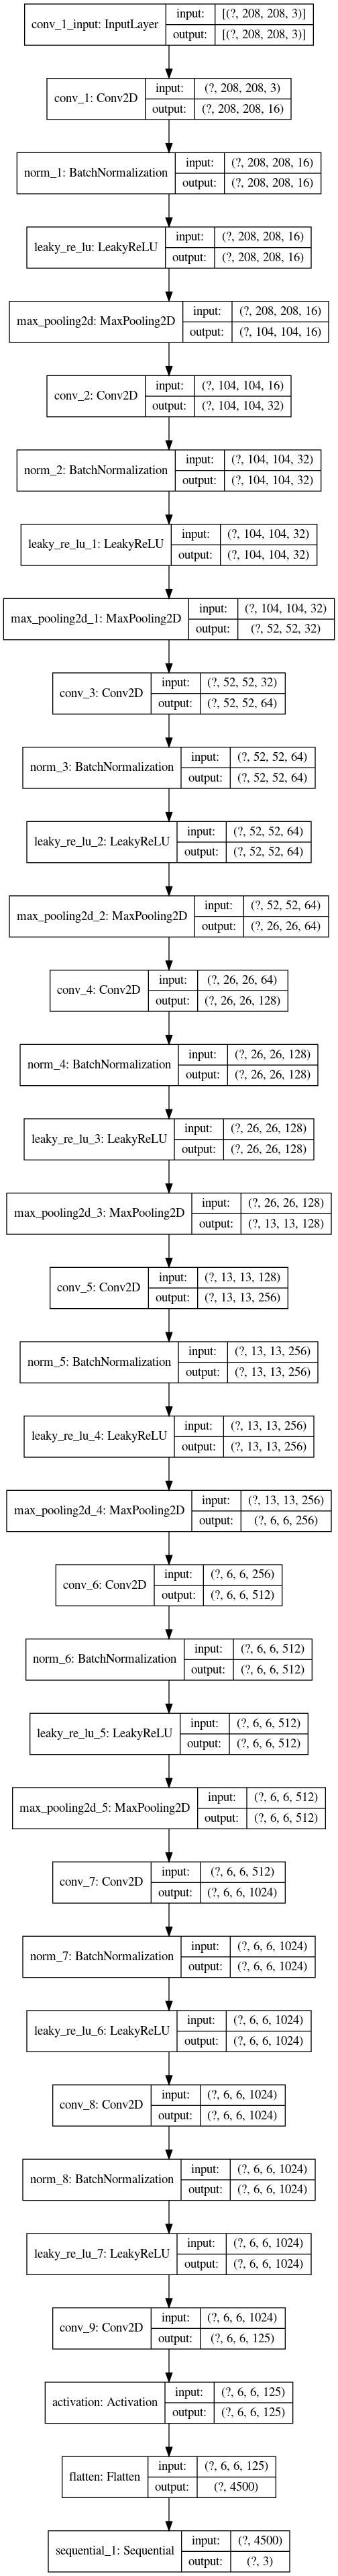

In [19]:
# Plot detailed model

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
# Make first layers untrainable

layer_count = len(model.layers)
head_count = len(model_head_holder.layers)
for i in range(layer_count-head_count+1):
    model.layers[i].trainable= False

In [21]:
# Compile model

model.compile(optimizer=SGD(lr=1e-4, momentum=0.9),loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [22]:
# Data generators, etc

batch_size = 16
epochs = 10

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)
valid_generator = valid_datagen.flow(
    x_valid,
    y_valid,
    batch_size=batch_size
)

model.fit_generator(
    train_generator, 
    steps_per_epoch=x_train.shape[0]//batch_size, 
    epochs = epochs, 
    validation_data=valid_generator,
    validation_steps=x_valid.shape[0]//batch_size
)

Epoch 1/10
31/31 [==============================] - 7s 225ms/step - loss: 0.1907 - accuracy: 0.9731 - val_loss: 0.2257 - val_accuracy: 0.9464
Epoch 2/10
31/31 [==============================] - 5s 168ms/step - loss: 0.1539 - accuracy: 0.9669 - val_loss: 0.1657 - val_accuracy: 0.9464
Epoch 3/10
31/31 [==============================] - 5s 167ms/step - loss: 0.1316 - accuracy: 0.9690 - val_loss: 0.1463 - val_accuracy: 0.9375
Epoch 4/10
31/31 [==============================] - 5s 168ms/step - loss: 0.1091 - accuracy: 0.9711 - val_loss: 0.1400 - val_accuracy: 0.9464
Epoch 5/10
31/31 [==============================] - 5s 166ms/step - loss: 0.0757 - accuracy: 0.9835 - val_loss: 0.1489 - val_accuracy: 0.9554
Epoch 6/10
31/31 [==============================] - 5s 167ms/step - loss: 0.0183 - accuracy: 0.9917 - val_loss: 0.1526 - val_accuracy: 0.9554
Epoch 7/10
31/31 [==============================] - 5s 170ms/step - loss: 0.0730 - accuracy: 0.9855 - val_loss: 0.1542 - val_accuracy: 0.9554
Epoch 

## Test Network

In [23]:
x,y = next(valid_generator)

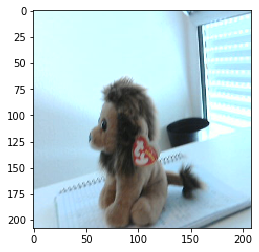

'lion'

In [24]:
index = 6
plt.imshow(x[index])
plt.show()

preds = model.predict(x[index:index+1])
pred = preds[0]
labels = ['nothing', 'bottle', 'lion']
pred = [round(x) for x in pred]
labels[pred.index(max(pred))]

## Export Tensorflow Graph

In [25]:
model.save('full-model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: full-model/assets


In [29]:
model.save_weights('check/check_point')

In [27]:
import tensorflow as tf
print(tf.version.VERSION)


2.0.0


### Resources

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://github.com/DevendraPratapYadav/tiny_yolo
- https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb